# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsforecast.models import MSTL
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series



c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão ao PostgreSQl

In [2]:
# user = "avnadmin"
# password = "AVNS_9fZb3BkX9qGXxKpxsrZ"
# host = "postgresql-iscac.f.aivencloud.com"
# port = "25674"
# bucket = "Seasonality"

# # URL de conexão com PostgreSQL
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{bucket}')

# #Nome da tabela 
# meteorology ='bicycle_counter'

# Importar dados do PostgreSQL

In [2]:
# Como a Api ainda não esta a funcionar, vou importar os dados de um csv
df = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\all_bike_counts.csv", parse_dates=['detected'], dtype='int32')
df = df.set_index('detected')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22632 entries, 2021-08-01 00:00:00 to 2024-02-29 23:00:00
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   22632 non-null  int32
 1   count_2       22632 non-null  int32
 2   direction_3   22632 non-null  int32
 3   count_3       22632 non-null  int32
 4   direction_4   22632 non-null  int32
 5   count_4       22632 non-null  int32
 6   direction_5   22632 non-null  int32
 7   count_5       22632 non-null  int32
 8   direction_6   22632 non-null  int32
 9   count_6       22632 non-null  int32
 10  direction_7   22632 non-null  int32
 11  count_7       22632 non-null  int32
 12  direction_8   22632 non-null  int32
 13  count_8       22632 non-null  int32
 14  direction_9   22632 non-null  int32
 15  count_9       22632 non-null  int32
 16  direction_10  22632 non-null  int32
 17  count_10      22632 non-null  int32
 18  direction_11  22632 non-null  i

In [3]:
df_loc = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\all_counter_locations.csv")
df_loc.info()
print()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB



# Análises

### 1.Visualizar todas as localizações

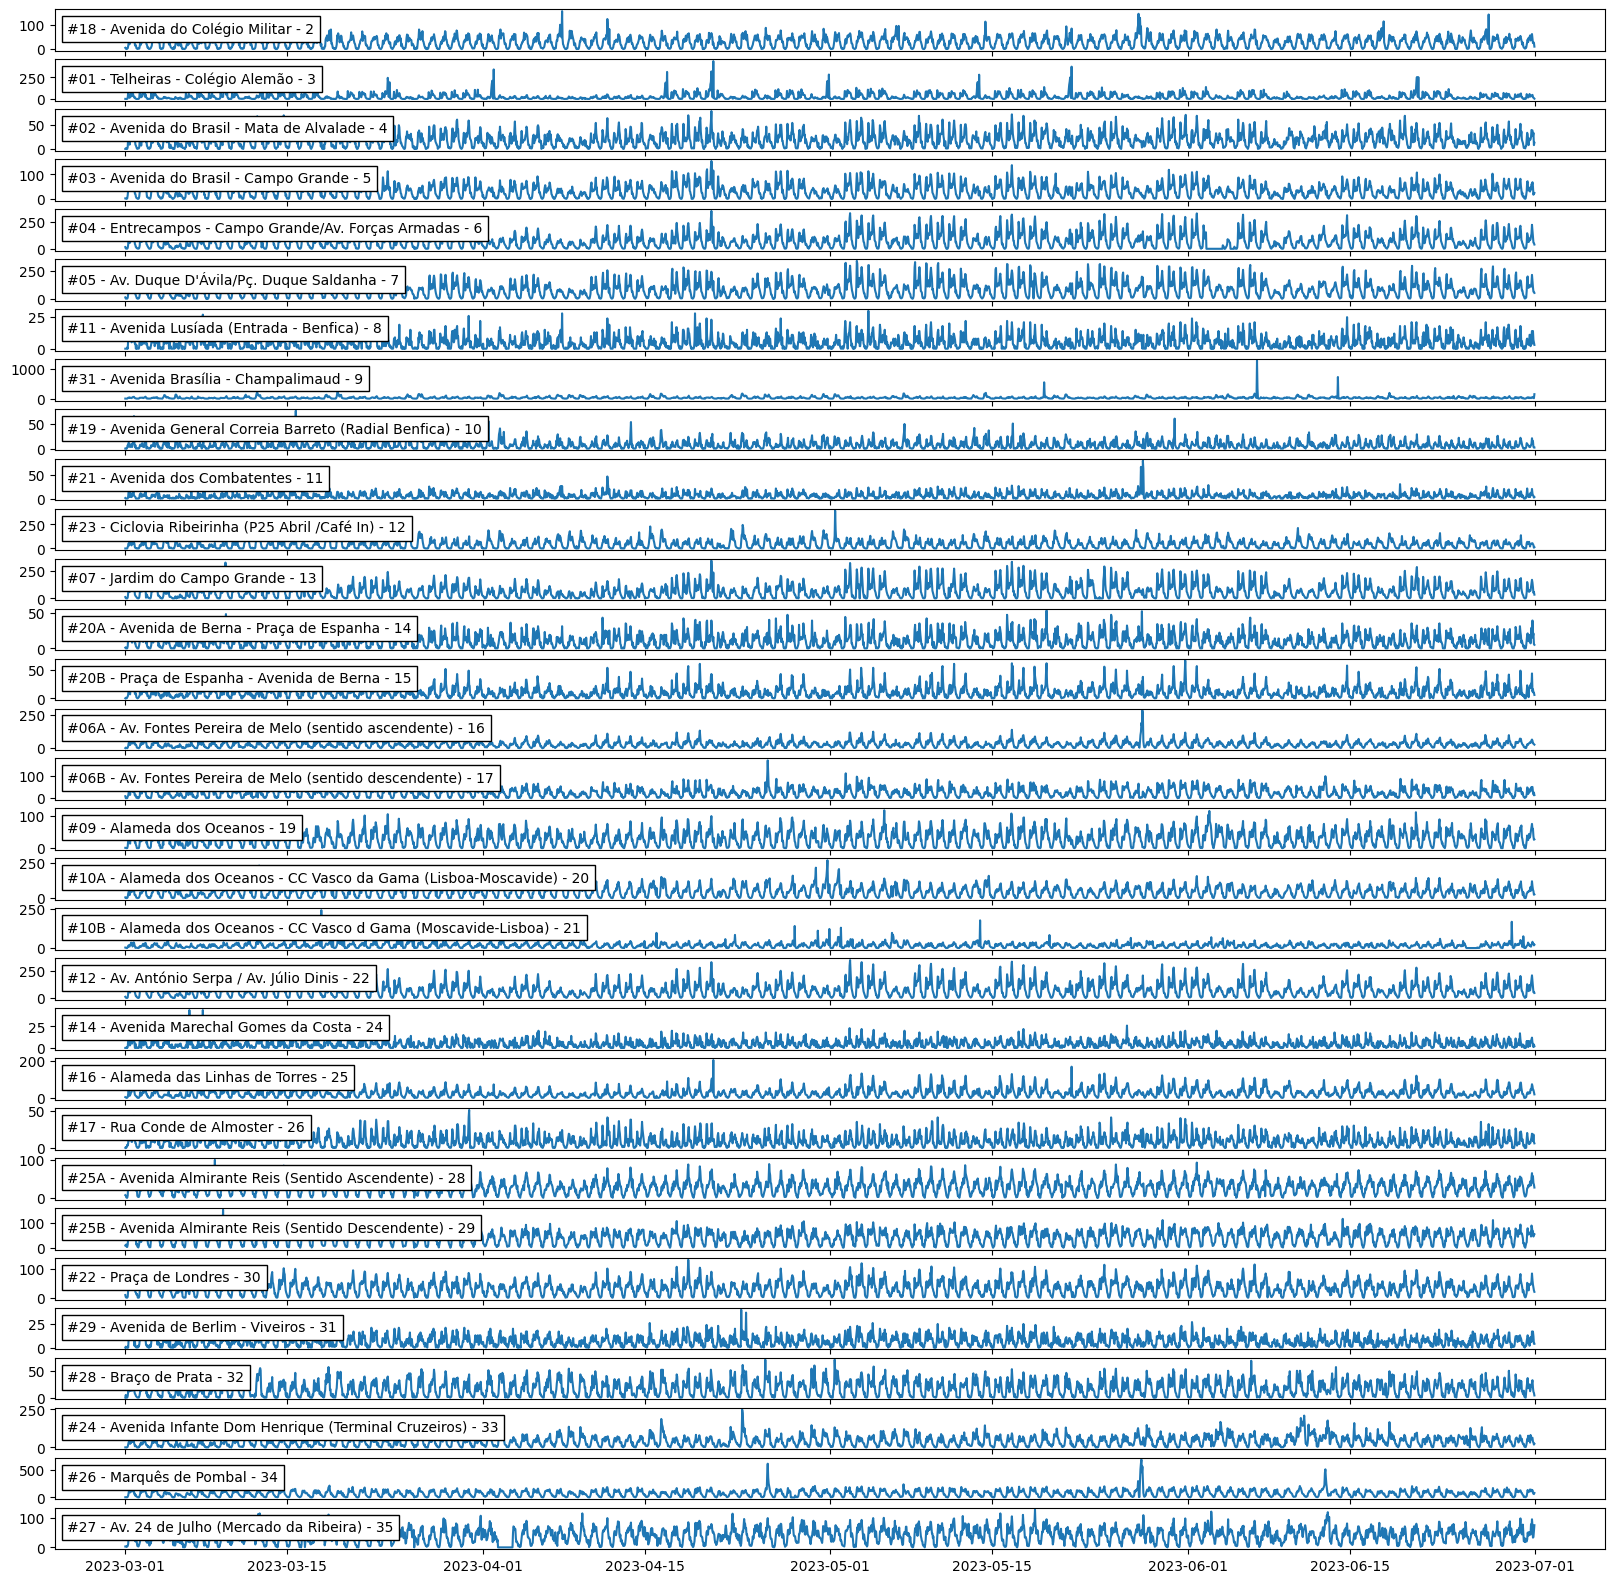

In [4]:
locationId_all = df_loc.locationId.to_list()  # converte a coluna location numa lista
locationId_remove = [] # lista de ID´s que se pretende remover, mas neste caso esta vazia
locationId_keep = [elem for elem in locationId_all if elem not in locationId_remove] #Filtra esses IDs com base em locationId_remove para obter os IDs a serem mantidos

fig, ax = plt.subplots(len(locationId_keep), 1, figsize=(20,20), sharex=True) # grafico que vai criar varios subplots, sendo que o tamanho do  gráfico é igual ao número de id´s
for i,location in enumerate(locationId_keep):
    ax[i].plot(df.query('"2023-03"<index<"2023-07"').loc[:,f'count_{location}']) #intervalo das datas que se pretende ver o gráfico
    counter_name = AnchoredText(df_loc.query('locationId == @location').name.values[0] + ' - ' + str(location), loc="upper left")
    ax[i].add_artist(counter_name)
plt.show()

In [13]:
import folium

# Filtrar apenas os contadores 8 e 12
df_filtrado = df_loc[df_loc['locationId'].isin([8, 12])]

# Criar o mapa centrado em Lisboa (ou noutra média se quiseres ser mais preciso)
map = folium.Map(location=[38.736946, -9.142685], zoom_start=13)

# Criar lista de pontos e tooltips
point_list = [[i, j] for i, j in zip(df_filtrado.latitude, df_filtrado.longitude)]
tooltip_list = [f'{i} >> locationId = {j}' for i, j in zip(df_filtrado.name, df_filtrado.locationId)]

# Adicionar marcadores ao mapa
for point, tooltip in zip(point_list, tooltip_list):
    folium.Marker(point, popup='Contador', tooltip=tooltip).add_to(map)

# Mostrar o mapa
map






### Visualização sazonal

In [6]:
# Prepação dos dados para o gráfico
def prep_df_fig(df_all, start_date, end_date, column):
    df_raw = df_all.query('@start_date <= index < @end_date').filter([column])
    df_raw = df_raw.assign(
        woy = df_raw.index.isocalendar().week,
        dow = df_raw.index.dayofweek,
        hod = df_raw.index.hour
        ).reset_index()
    df_raw = df_raw.assign(idx = (df_raw.dow)*24 + df_raw.hod)
    df_fig = df_raw.pivot(index='idx', columns='woy', values=column)
    df_fig = df_fig.assign(mean_hour = df_fig.agg('mean', axis=1))
    return df_fig

# Gera uma lista de posições para o eixo X (ticks) com base em dias e horas. 
def prep_ticks_fig(hour_list):
    hour_list_aux = [0] + hour_list
    tick_list = []
    tick_label_list = []
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i,d in zip(np.arange(0, 167, 24),days):
        tick_list_aux = hour_list_aux + i
        tick_list = tick_list + tick_list_aux.tolist()
        tick_label_list_aux = [d] + [str(h)+':00' for h in hour_list]
        tick_label_list = tick_label_list + tick_label_list_aux
    return tick_list, tick_label_list

# Faz o gráfico de linhas
def plot_weekly_count(df_all, df_all_loc, start_date, end_date, loc, hour_list):
    location_name = df_all_loc.query('locationId == @loc').name.values[0]
    column = 'count_' + str(location)
    df_plot = prep_df_fig(df_all, start_date, end_date, column)
    tick_list, tick_label_list = prep_ticks_fig(hour_list)
    fig,ax = plt.subplots(1, 1, figsize=(26,4))
    for i in tick_list:
        if i in np.arange(0, 167, 24):
            ax.axvline(i, color='cadetblue', linestyle='dashed', linewidth=1.5)
        else:
            ax.axvline(i, color='aliceblue', linestyle='dashed')
    for i in list(range(len(df_plot.columns[:-1]))):
        ax.plot(df_plot.iloc[:,i], color='gray', alpha=0.15, linewidth=1.5)
    ax.plot(df_plot.iloc[:,-1], color='indianred', alpha=0.8, linewidth=1.5, label='mean')
    plt.xticks(ticks=tick_list, labels=tick_label_list)
    ax.set_title(f'Weekly count at {location_name}   ({start_date} - {end_date})')
    ax.legend()
    plt.show()

# Faz o gráfico de barras
def plot_weekly_bar_count(df_all, df_all_loc, start_date, end_date, loc, hour_list):
    # Filtrar o nome da localização
    location_name = df_all_loc.query('locationId == @loc').name.values[0]
    
    # Selecionar a coluna de contagem baseada no ID da localização
    column = f'count_{location}'
    
    # Preparar os dados com a função já existente
    df_plot = prep_df_fig(df_all, start_date, end_date, column)
    tick_list, tick_label_list = prep_ticks_fig(hour_list)
    
    # Calcular a média de contagem por hora/dia
    mean_per_hour = df_plot.iloc[:, :-1].mean(axis=1)
    
    # Criar o gráfico de barras
    fig, ax = plt.subplots(figsize=(26, 4))
    ax.bar(df_plot.index, mean_per_hour, color='skyblue', alpha=0.8, label='Mean Count')

    # Adicionar divisões nos dias da semana
    for i in np.arange(0, 167, 24):
        ax.axvline(i, color='cadetblue', linestyle='dashed', linewidth=1.5)

    # Configurar o eixo X com os rótulos de horas e dias
    plt.xticks(ticks=tick_list, labels=tick_label_list, rotation=45, ha='right')
    ax.set_title(f'Weekly Count (Bar Plot) at {location_name} ({start_date} - {end_date})')
    ax.set_ylabel('Mean Count')
    ax.legend()
    plt.tight_layout()
    plt.show()

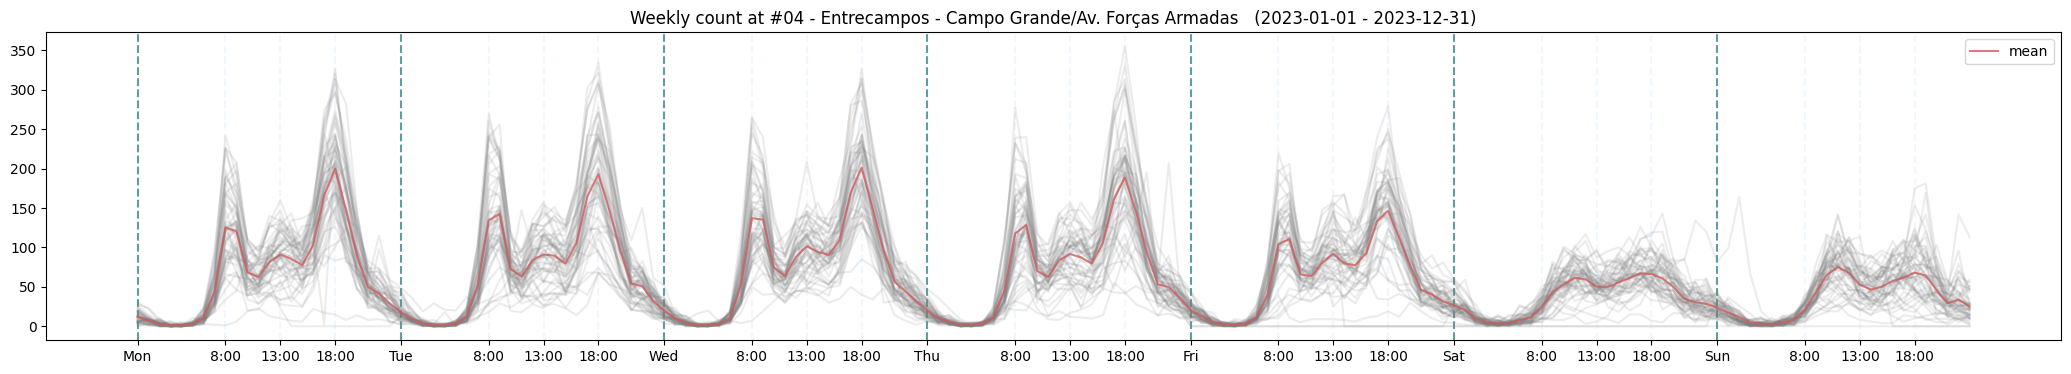

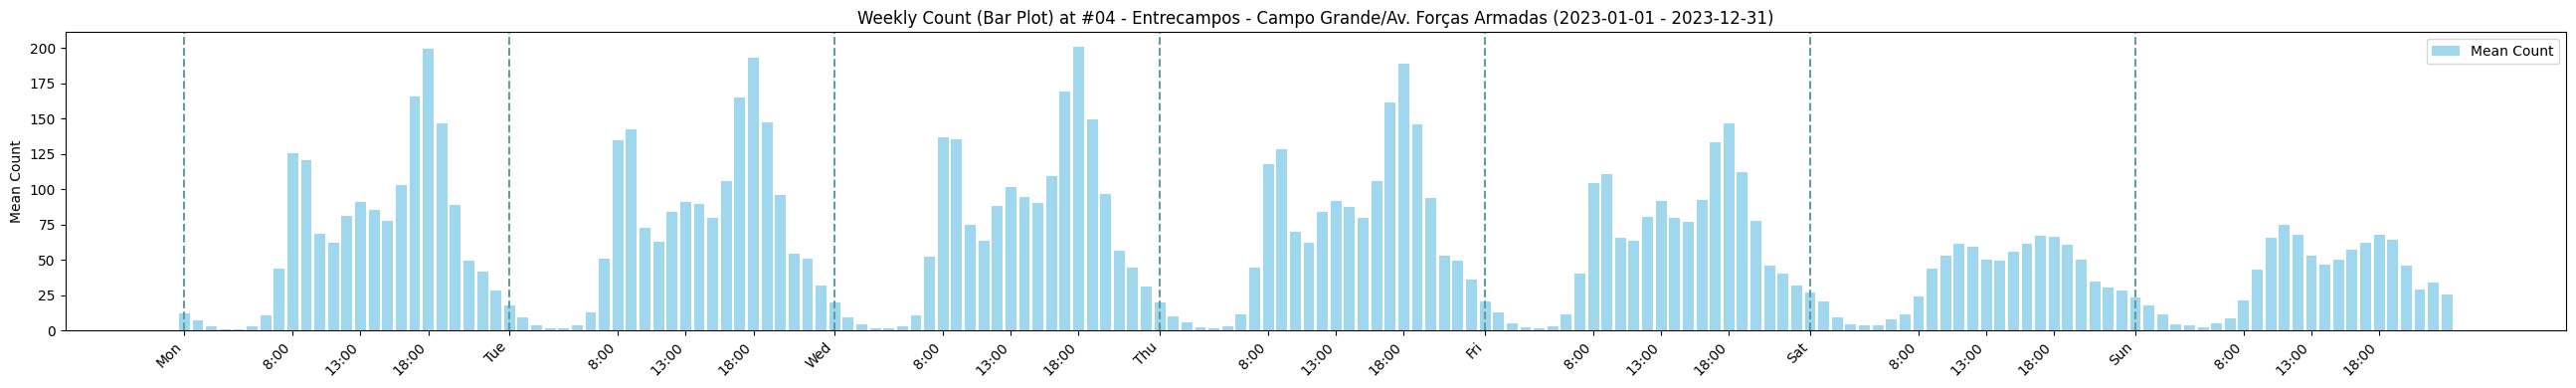

In [7]:
# Para o ano 2023 completo
location = 6
s_date = "2023-01-01"
e_date = "2023-12-31"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

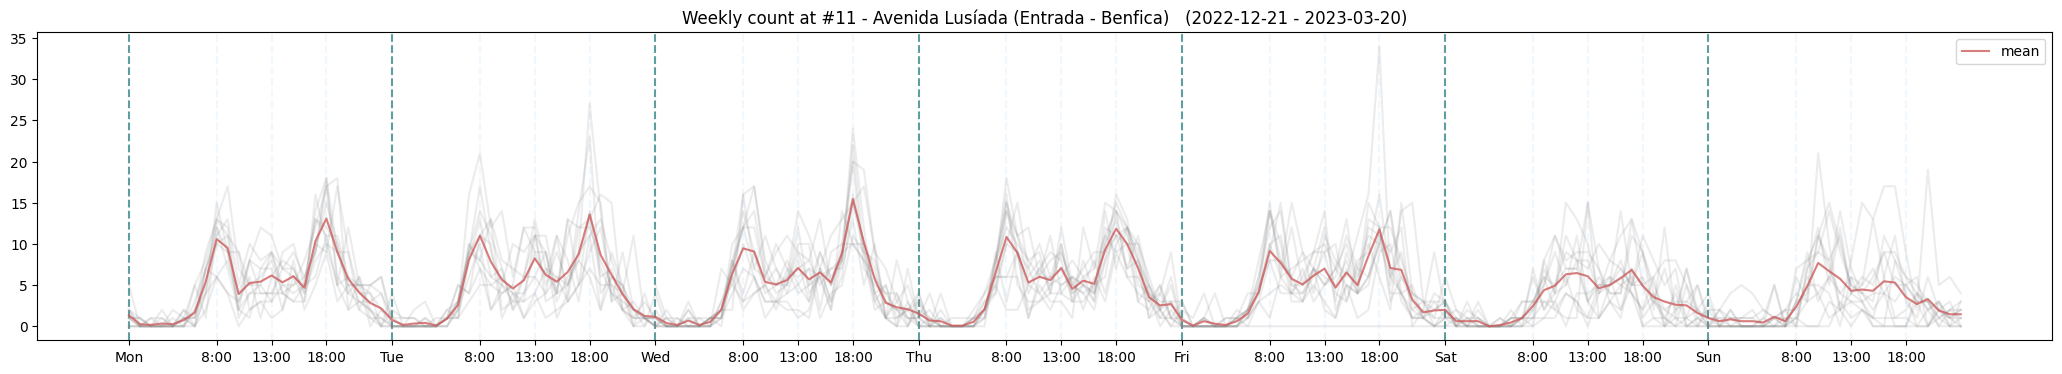

In [8]:
# inverno
location = 8
s_date = "2022-12-21"
e_date = "2023-03-20"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)

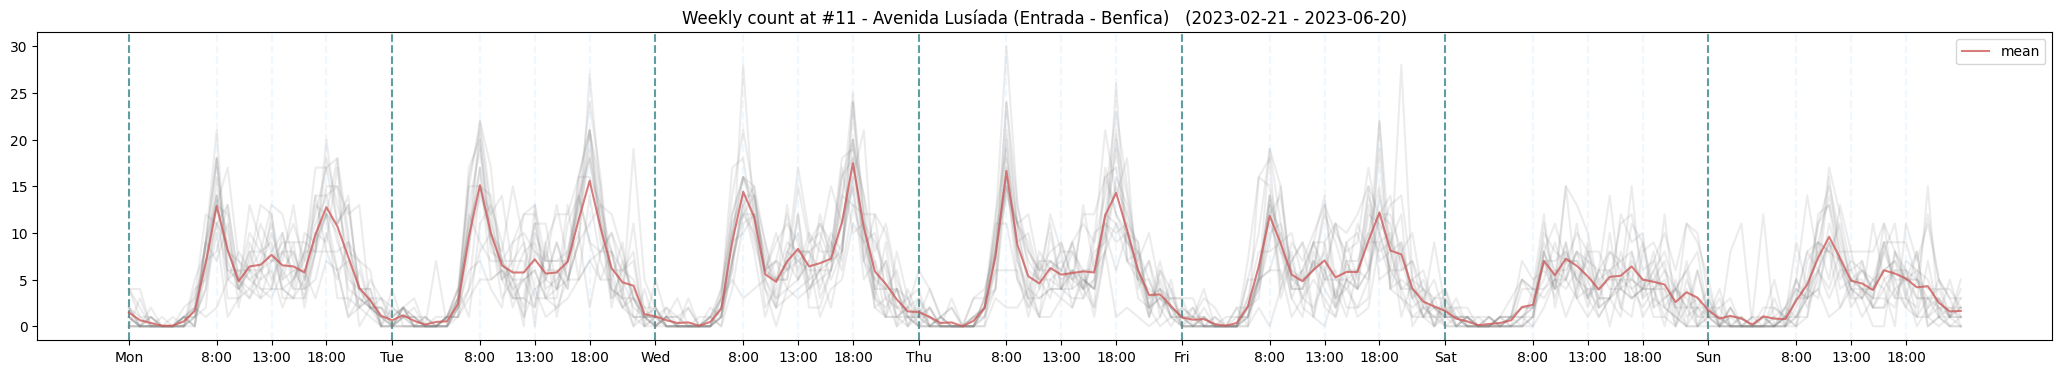

In [9]:
# primavera
location = 8
s_date = "2023-02-21"
e_date = "2023-06-20"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)

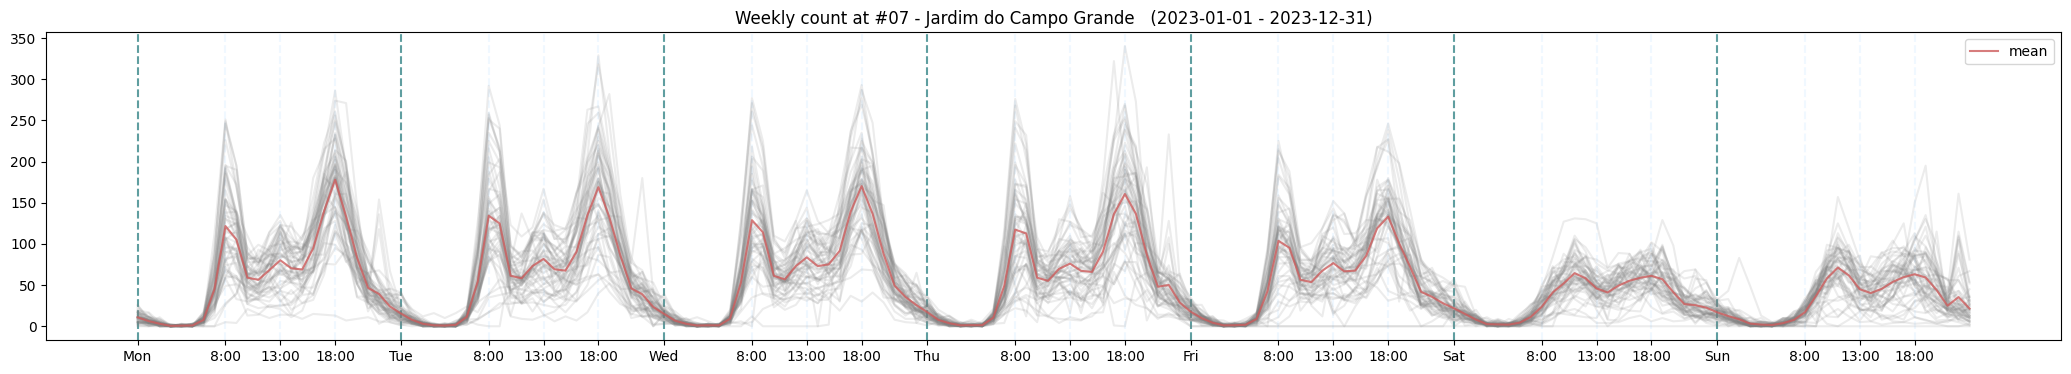

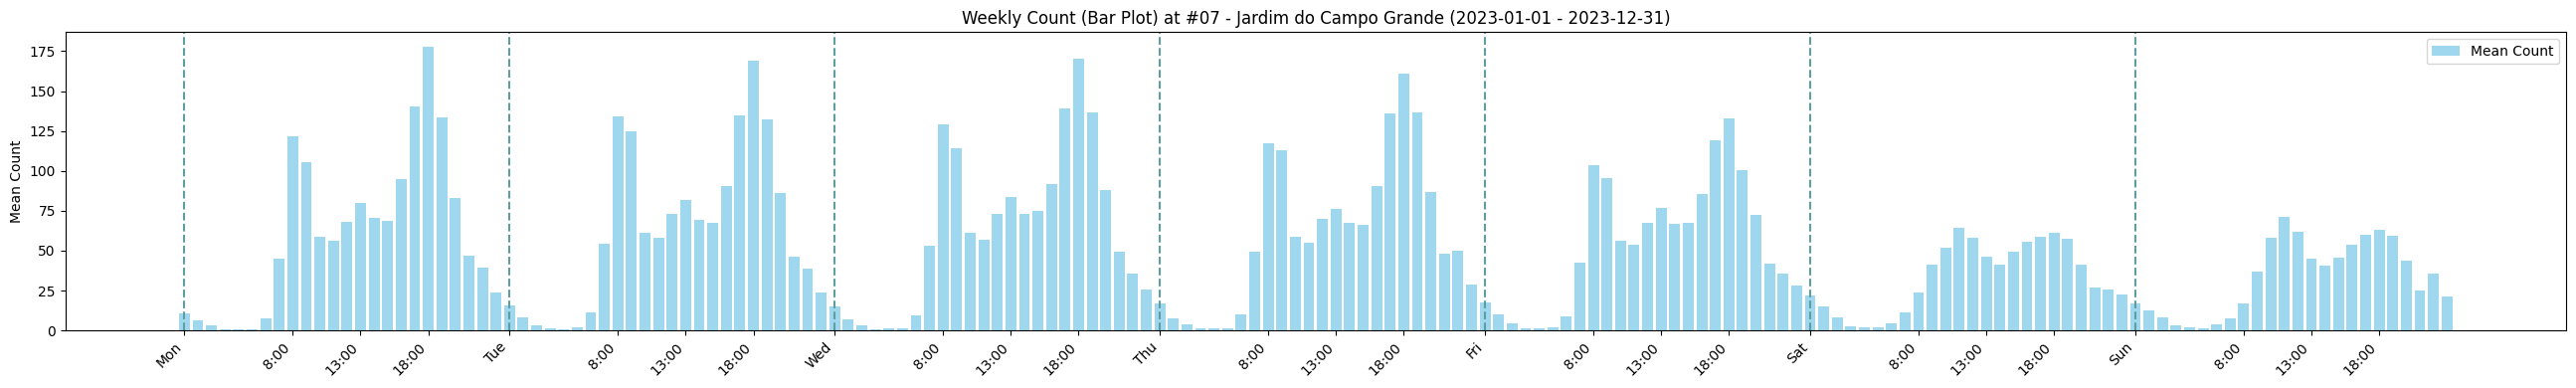

In [10]:
# para o ano 2023 mas para a localidade 13
location = 13
s_date ="2023-01-01"
e_date = "2023-12-31"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

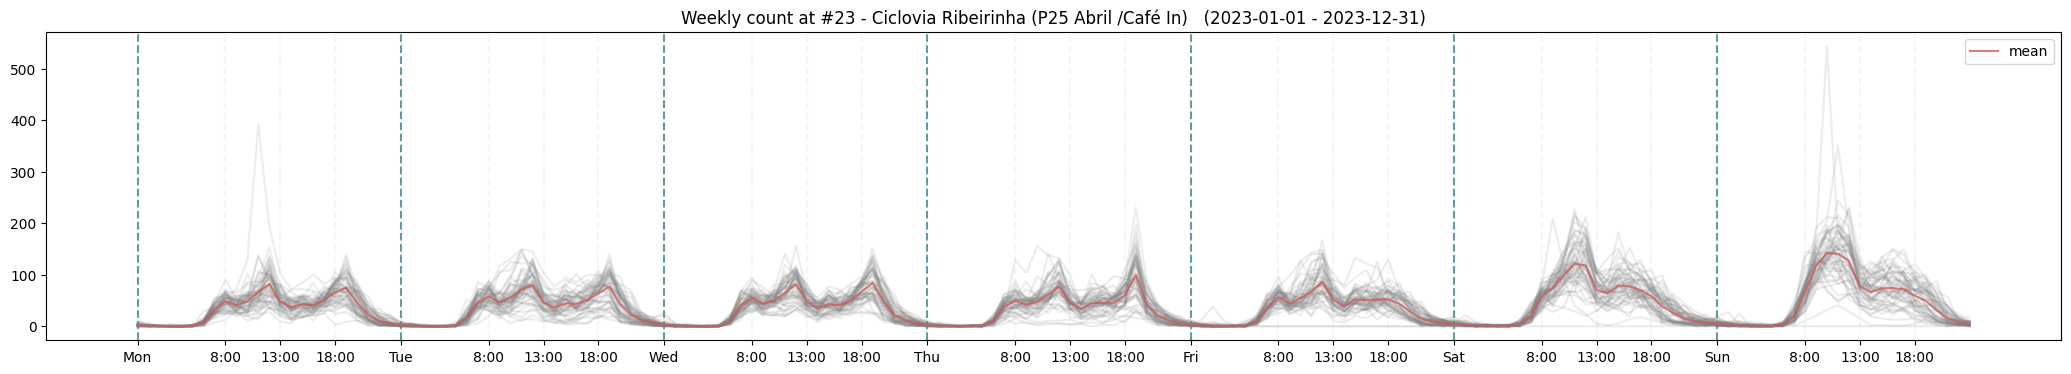

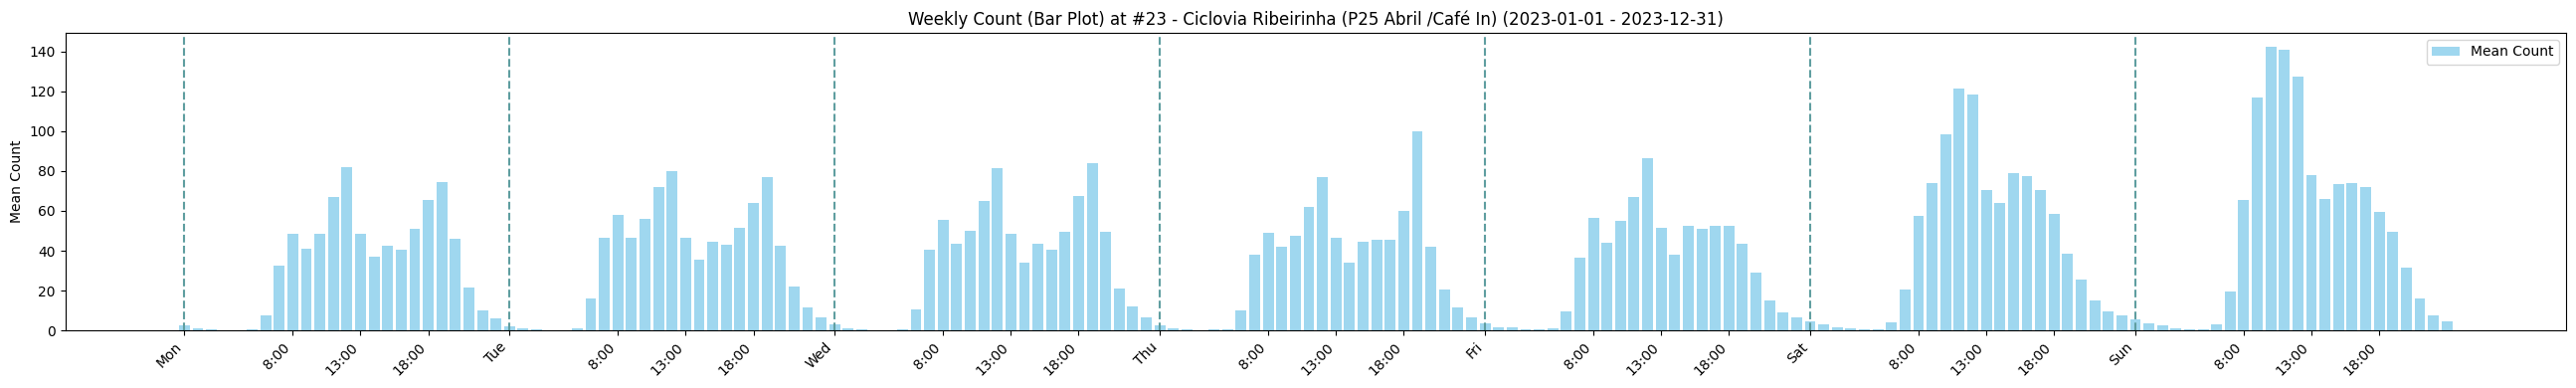

In [11]:
#para a localidade 12 no ano 2023 (temos maior uso ao fim de semana)
location = 12
s_date ="2023-01-01"
e_date = "2023-12-31"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

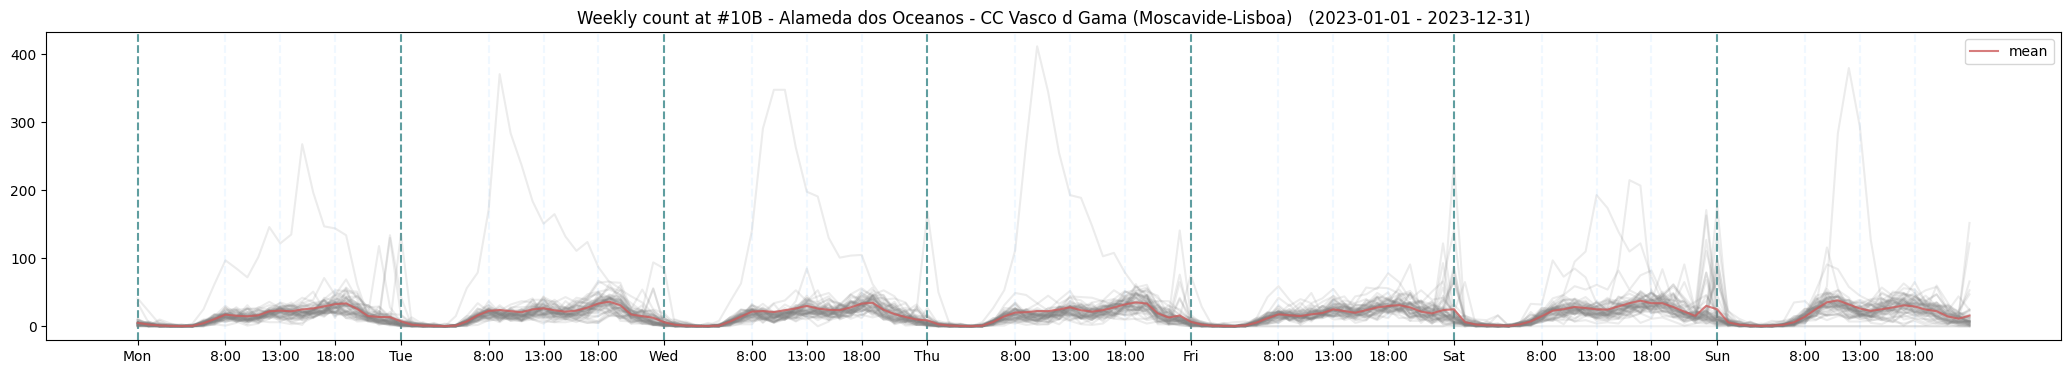

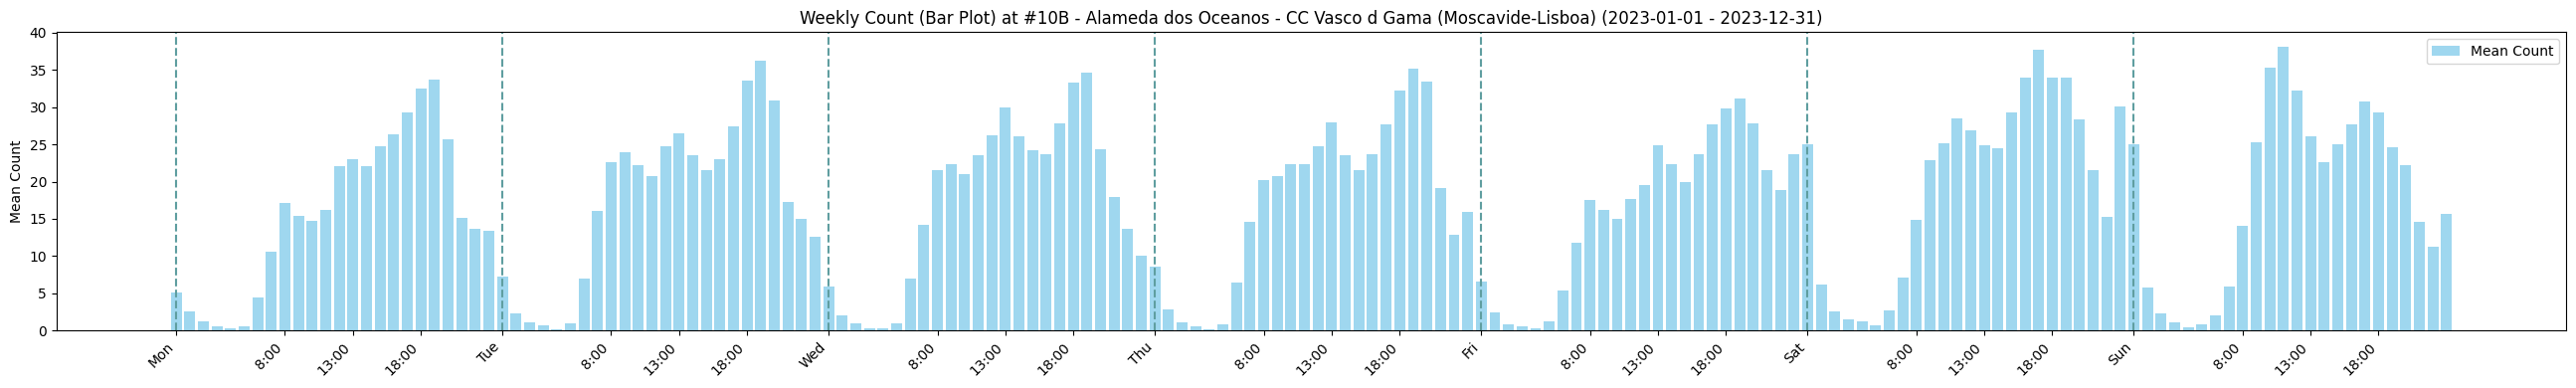

In [12]:
# Localizaçãp 21 para o ano 2023 (o uso é relativamente baixo e constante ao longo da semana e fim de semana)
location = 21
s_date ="2023-01-01"
e_date = "2023-12-31"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

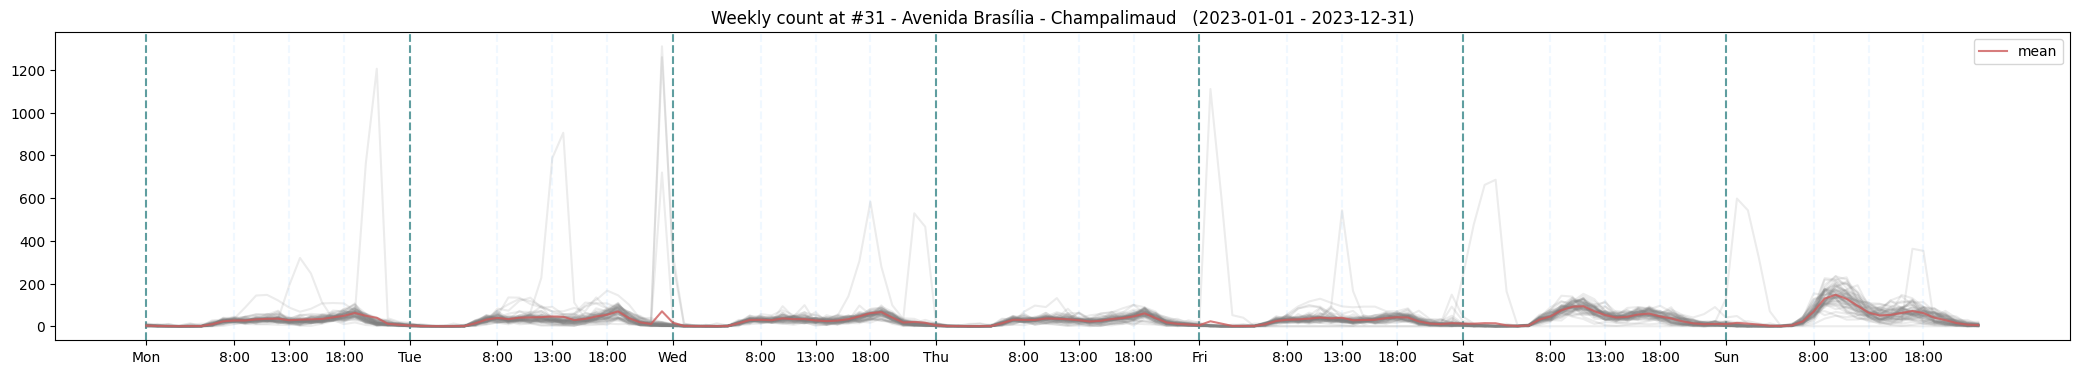

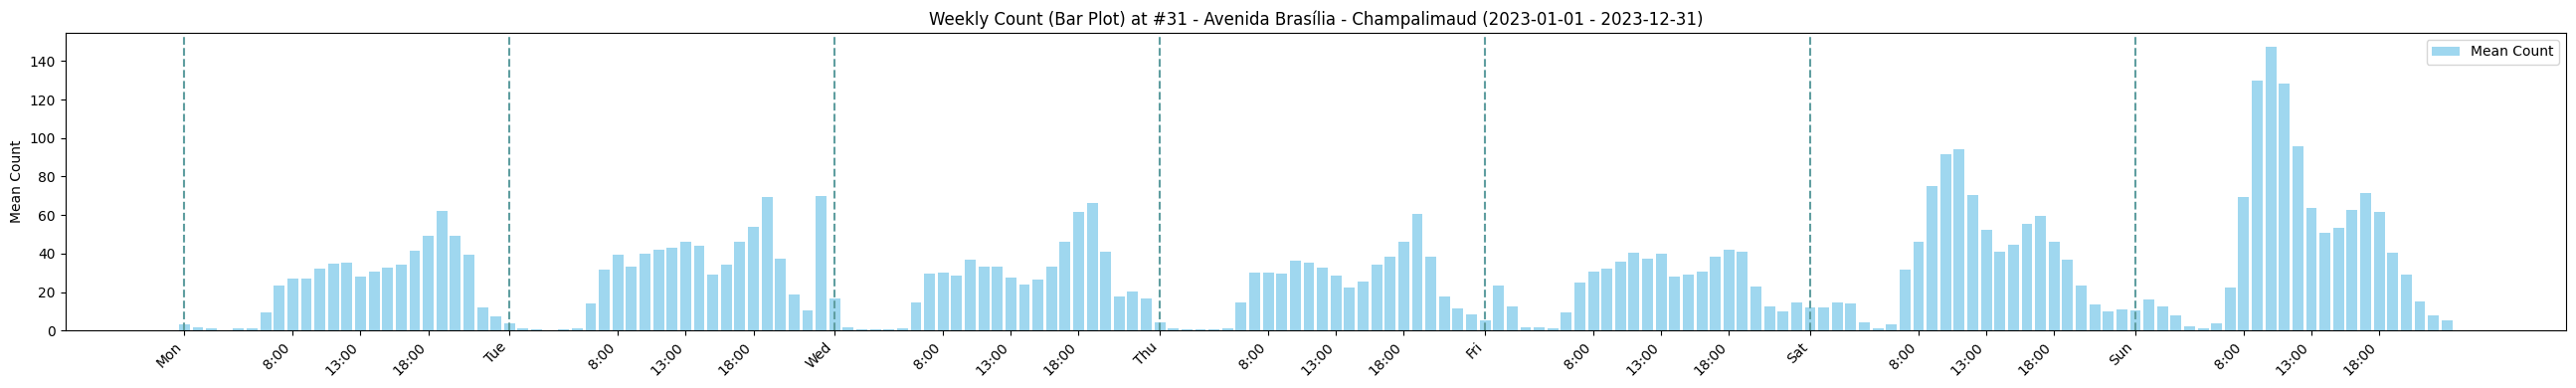

In [13]:
#localização 9 para o ano 2023 (utilização maior ao fim de semana)
location = 9
s_date ="2023-01-01"
e_date = "2023-12-31"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

### Comparação das estações do ano

In [14]:
def get_season(date):
    if date.month in [12, 1, 2] or (date.month == 3 and date.day < 21):
        return 'Winter'
    elif date.month in [3, 4, 5] or (date.month == 6 and date.day < 21):
        return 'Spring'
    elif date.month in [6, 7, 8] or (date.month == 9 and date.day < 21):
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df.index.map(get_season)

# Preparar os dados para o gráfico de sazonalidade
def prep_seasonal_data(df_all, column):
    df_seasonal = df_all.groupby(['season', df_all.index.hour])[column].mean().unstack(level=0)
    return df_seasonal

def get_location_name(location_id, df_loc):
    return df_loc.query('locationId == @location_id').name.values[0]

# Gráfico de sazonalidade com linhas e título ajustado
def plot_seasonal_line_with_labels(df_all, df_loc, column, location, hour_list):
    location_name = get_location_name(location, df_loc)
    
    # Preparar os dados
    df_seasonal = prep_seasonal_data(df_all, column)
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plotar as linhas
    for season in df_seasonal.columns:
        ax.plot(df_seasonal.index, df_seasonal[season], label=season)
        
        # Adicionar o nome da estação próximo ao final da linha
        ax.text(
            x=df_seasonal.index[-1],  # Último valor do eixo X
            y=df_seasonal[season].iloc[-1],  # Último valor da linha no eixo Y
            s=season,  # Nome da estação
            fontsize=10, color=ax.lines[-1].get_color(),  # Mesma cor da linha
            ha='left', va='center'
        )
    
    # Configurações do gráfico
    ax.set_title(f'Seasonal Trends (Hourly Averages) - {location_name}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Count')
    ax.set_xticks(hour_list)  # Ajustar os horários no eixo X
    ax.set_xticklabels([f'{h}:00' for h in hour_list])
    ax.legend(title='Season')
    plt.grid(alpha=0.3)
    plt.show()

# Gráfico de sazonalidade com barras
def plot_seasonal_bar(df_all, column):
    df_seasonal = prep_seasonal_data(df_all, column)
    df_seasonal.plot(kind='bar', figsize=(14, 8), alpha=0.75)
    plt.title('Seasonal Trends (Hourly Averages)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Count')
    plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()



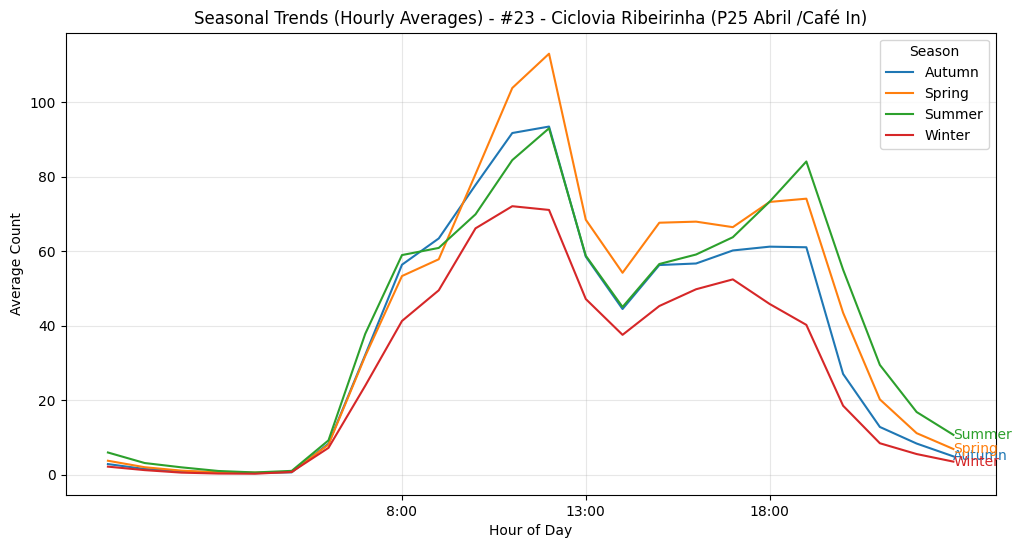

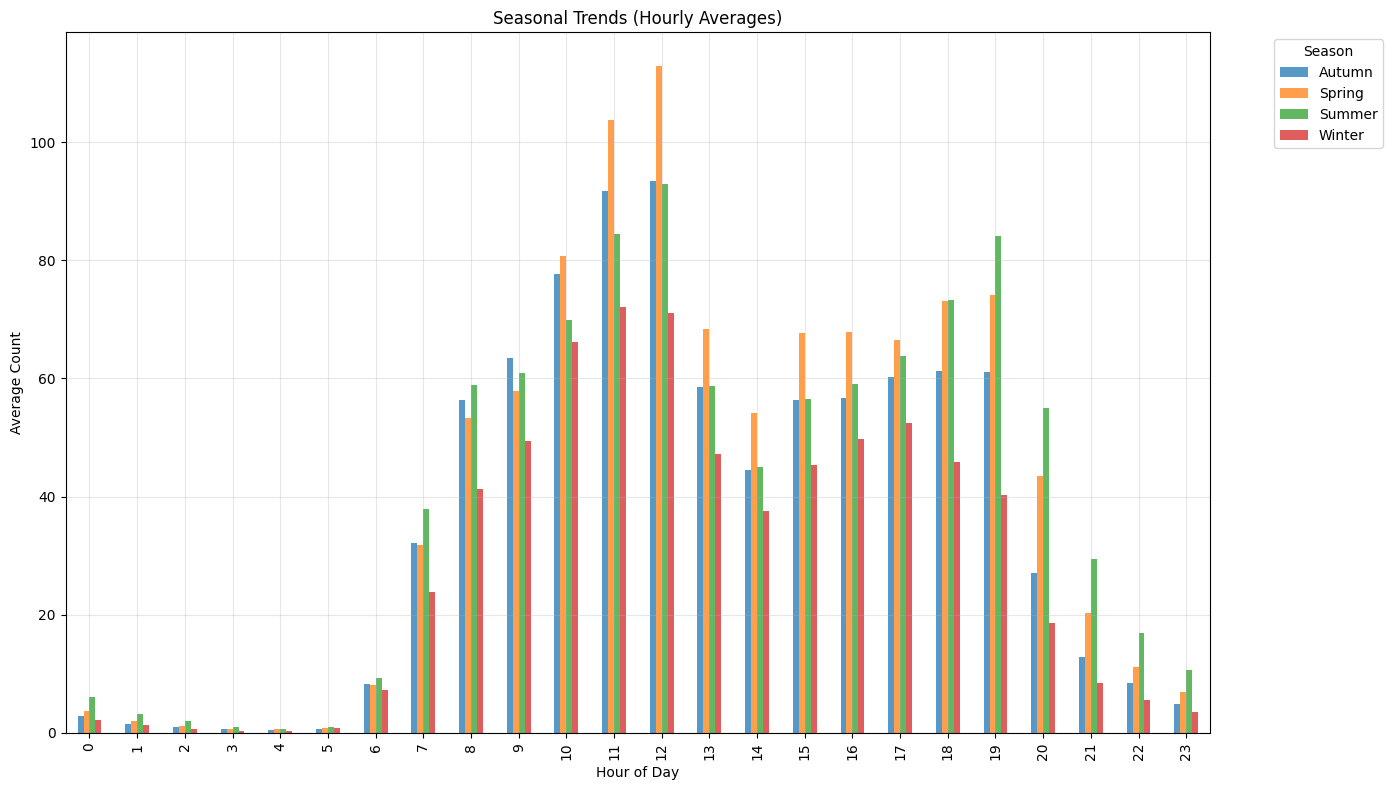

In [15]:
location = 12
column = f'count_{location}'
hour_list = [8, 13, 18]
plot_seasonal_line_with_labels(df, df_loc, column, location, hour_list)
plot_seasonal_bar(df, column)

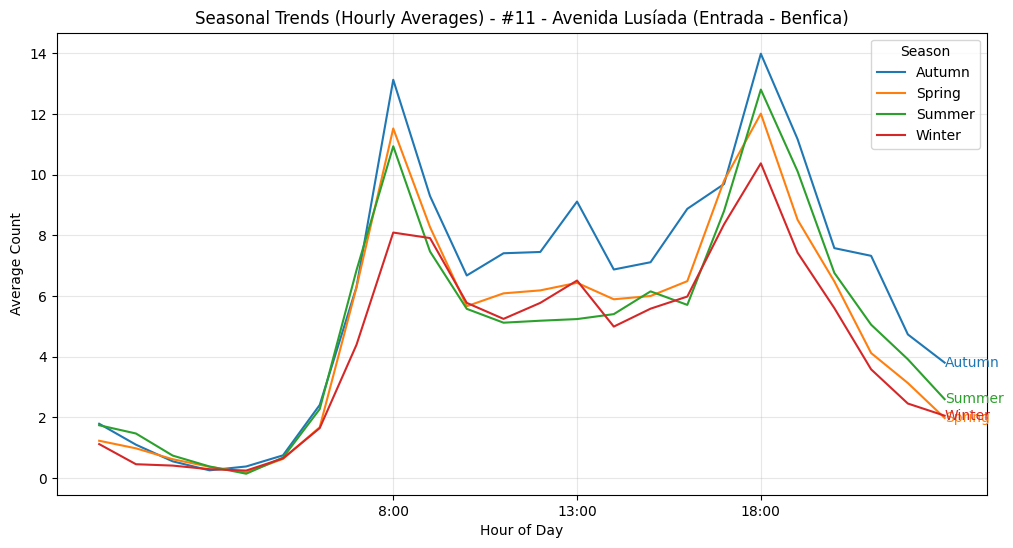

In [16]:
# Para apenas o ano de 2023
df_filtered = df[df.index.year == 2023]
location = 8
column = f'count_{location}'
hour_list = [8, 13, 18]
plot_seasonal_line_with_labels(df_filtered, df_loc, column, location, hour_list)

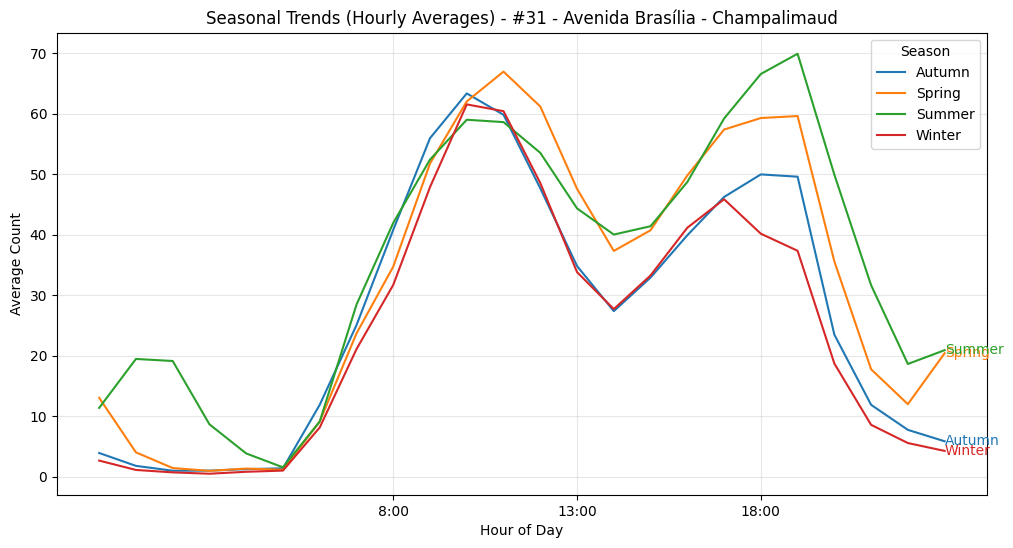

In [17]:
# para a localização 9
location = 9
column = f'count_{location}'
hour_list = [8, 13, 18]
plot_seasonal_line_with_labels(df, df_loc, column, location, hour_list)

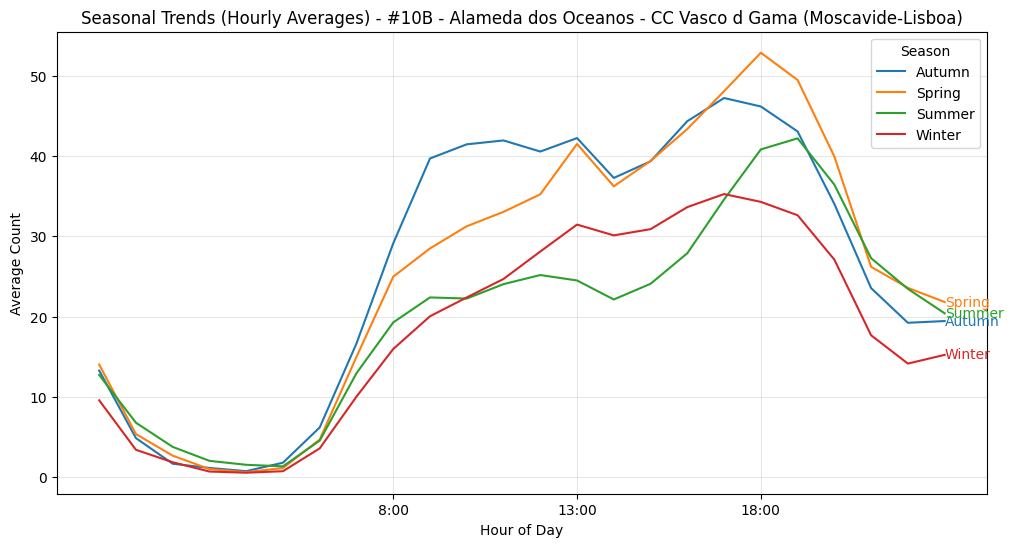

In [18]:
# para a locazação 21
location = 21
column = f'count_{location}'
hour_list = [8, 13, 18]
plot_seasonal_line_with_labels(df, df_loc, column, location, hour_list)

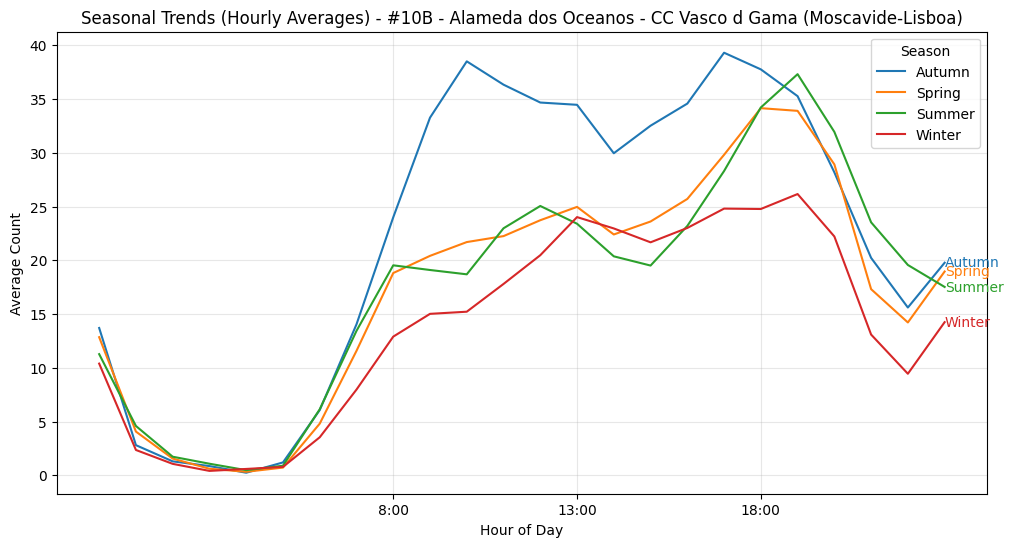

In [19]:
# Para apenas o ano de 2023
df_filtered = df[df.index.year == 2023]
location = 21
column = f'count_{location}'
hour_list = [8, 13, 18]
plot_seasonal_line_with_labels(df_filtered, df_loc, column, location, hour_list)

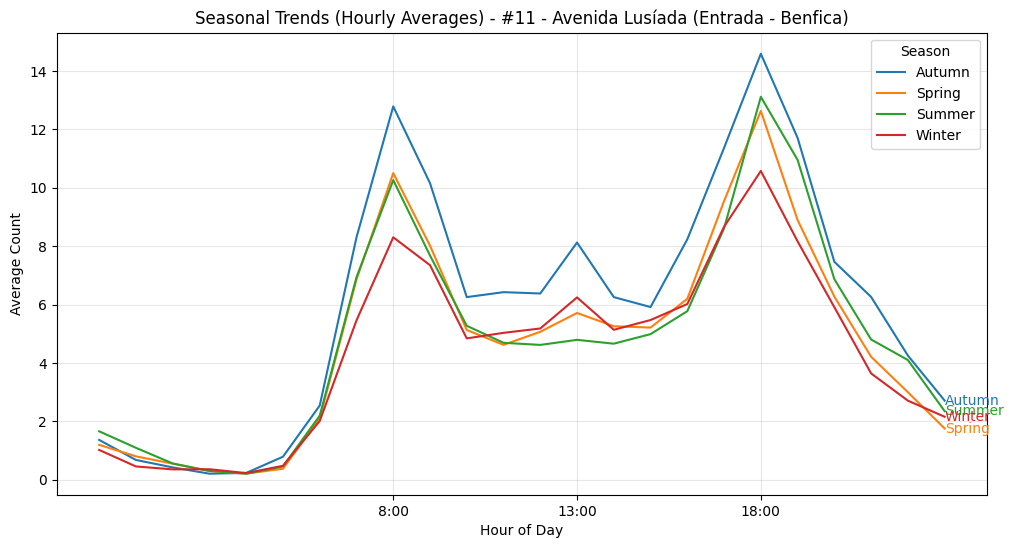

In [20]:
# Gráfico para dias úteis (segunda a sexta-feira)
df_filtered_weekdays = df[df.index.weekday < 5]  # 0 = segunda-feira, 4 = sexta-feira
location = 8
column = f'count_{location}'
hour_list = [8, 13, 18]
# Chamar a função com o DataFrame filtrado
plot_seasonal_line_with_labels(df_filtered_weekdays, df_loc, column, location, hour_list)


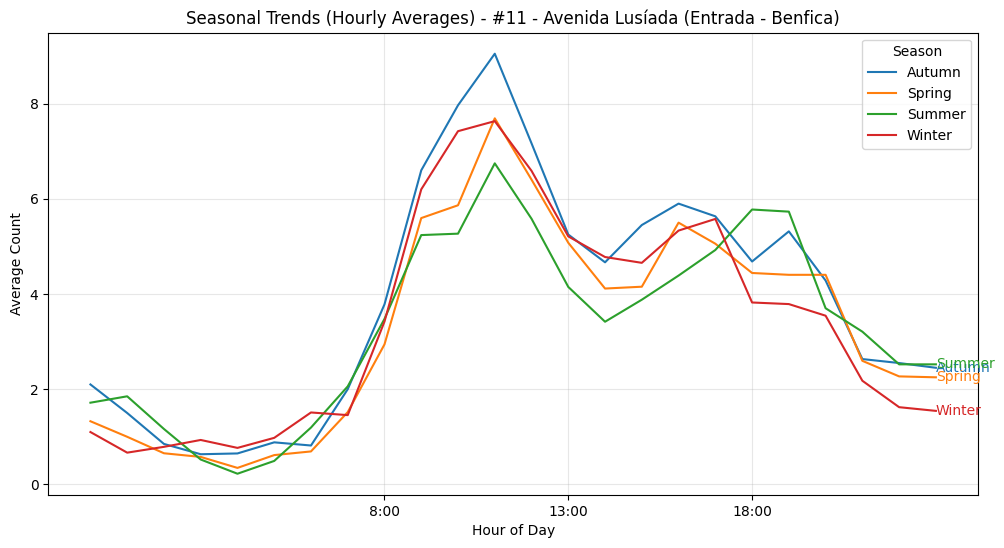

In [21]:
# Gráfico para o fim de semana 
df_filtered_weekend = df[df.index.weekday >= 5] 
location = 8
column = f'count_{location}'
hour_list = [8, 13, 18]
plot_seasonal_line_with_labels(df_filtered_weekend, df_loc, column, location, hour_list)


In [22]:
import plotly.graph_objects as go
import plotly.io as pio
import nbformat


# Selecionar o locationId que você deseja (por exemplo, 1234)
locationId_select = 8  # Substitua pelo ID do contador que deseja plotar

# Filtra o DataFrame para o intervalo de datas e para o contador selecionado
df_filter = df.query('"2021-08" < index < "2024-12"')

# Criação do gráfico com Plotly
fig = go.Figure()

# Adiciona a linha do contador selecionado
fig.add_trace(go.Scatter(
    x=df_filtered.index,
    y=df_filtered[f'count_{locationId_select}'],
    mode='lines',
    name=df_loc.query('locationId == @locationId_select').name.values[0] + ' - ' + str(locationId_select)
))

# Adiciona o título e os rótulos dos eixos
fig.update_layout(
    title=f'Contador {locationId_select}: {df_loc.query("locationId == @locationId_select").name.values[0]}',
    xaxis_title='Data',
    yaxis_title='Contagem',
    template='plotly_dark'  # Mudar o tema, se necessário
)

# Exibe o gráfico interativo
pio.show(fig)


In [23]:
df_daily = df.resample('D').sum()
locationId_select = 8 
df_filtered = df_daily.query('"2023-05-01" <= index < "2023-06-01"')


In [ ]:
# Criar o gráfico de linha para o contador selecionado
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_filtered.index,
    y=df_filtered[f'count_{locationId_select}'],
    mode='lines',
    name=f'Contador {locationId_select}',
))


fig.update_layout(
    title=f'Contador {locationId_select}',
    xaxis_title='Data',
    yaxis_title='Contagem',
    template='plotly_dark',
    xaxis_rangeslider_visible=True  # Adiciona a barra de controle para o zoom
)

pio.show(fig)

In [24]:
locationId_select = 8

# Criar uma coluna com os dias da semana (0=Segunda, 1=Terça, ..., 6=Domingo)
df_filtered['day_of_week'] = df_filtered.index.dayofweek

# Criar uma coluna para o mês (1 = Janeiro, 12 = Dezembro)
df_filtered['month'] = df_filtered.index.month

# Função para determinar a estação do ano com base no mês
def get_season(month):
    if month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    elif month in [9, 10, 11]:
        return 'Outono'
    else:
        return 'Inverno'

# Criar uma coluna para as estações do ano
df_filtered['season'] = df_filtered['month'].apply(get_season)

# 1. Boxplot por Dia da Semana
fig_day_of_week = go.Figure()

for day in df_filtered['day_of_week'].unique():
    fig_day_of_week.add_trace(go.Box(
        y=df_filtered[df_filtered['day_of_week'] == day][f'count_{locationId_select}'],
        name={0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}[day],
        boxmean=True
    ))

fig_day_of_week.update_layout(
    title=f'Boxplot por Dia da Semana - Contador {locationId_select}',
    xaxis_title='Dia da Semana',
    yaxis_title='Contagem',
    template='plotly_dark'
)





C:\Users\joana\AppData\Local\Temp\ipykernel_19224\3071101075.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joana\AppData\Local\Temp\ipykernel_19224\3071101075.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joana\AppData\Local\Temp\ipykernel_19224\3071101075.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [26]:
# 2. Boxplot por Mês
fig_month = go.Figure()

for month in df_filtered['month'].unique():
    fig_month.add_trace(go.Box(
        y=df_filtered[df_filtered['month'] == month][f'count_{locationId_select}'],
        name={1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho', 7: 'Julho', 
              8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}[month],
        boxmean=True
    ))

fig_month.update_layout(
    title=f'Boxplot por Mês - Contador {locationId_select}',
    xaxis_title='Mês',
    yaxis_title='Contagem',
    template='plotly_dark'
)

In [ ]:

# 3. Boxplot por Estação do Ano
fig_season = go.Figure()

for season in df_filtered['season'].unique():
    fig_season.add_trace(go.Box(
        y=df_filtered[df_filtered['season'] == season][f'count_{locationId_select}'],
        name=season,
        boxmean=True
    ))

fig_season.update_layout(
    title=f'Boxplot por Estação do Ano - Contador {locationId_select}',
    xaxis_title='Estação do Ano',
    yaxis_title='Contagem',
    template='plotly_dark'
)

pio.show(fig_season)

In [25]:
df_daily

direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117      372   
2021-08-03          151      257          187      397          137      411   
2021-08-04          141      266          157      337          158      423   
2021-08-05          159      259          182      333          121      370   
...                 ...      ...          ...      ...          ...      ...   
2024-02-25          298      583           45      146          113      188   
2024-02-26          226      494          290      606          193      316   
2024-02-27          235      539          347      743          240      377   
2024-02-28          249      573          254      572          261      437   
2024-02-29          236      551          774     1793          265      433   

            direction_5  count_5  direction_6  count_6  ...  count_31  \
detected                                                ...             
2021-08-01          238      341          539      673  ...        94   
2021-08-02          249      364          735      907  ...       101   
2021-08-03          321      431          732      914  ...       117   
2021-08-04          306      404          706      890  ...       107   
2021-08-05          257      370          740      887  ...        81   
...                 ...      ...          ...      ...  ...       ...   
2024-02-25          123      339          192      515  ...        81   
2024-02-26          281      732          357     1270  ...       150   
2024-02-27          428     1053          433     1584  ...       155   
2024-02-28          379      972          456     1560  ...       160   
2024-02-29          370      937          493     1658  ...       163   

            direction_32  count_32  direction_33  count_33  direction_34  \
detected                                                                   
2021-08-01           359       500           401       769           354   
2021-08-02           377       486           355       590           436   
2021-08-03           426       568           441       699           376   
2021-08-04           439       563           379       626           430   
2021-08-05           456       584           367       602           424   
...                  ...       ...           ...       ...           ...   
2024-02-25            63       239           187       583           273   
2024-02-26            57       206           155       374           381   
2024-02-27            57       285           344       770           468   
2024-02-28            71       317           352       829           460   
2024-02-29            58       282           320       731           421   

            count_34  direction_35  count_35  \
detected                                       
2021-08-01       691           526      1149   
2021-08-02       777           523      1163   
2021-08-03       724           584      1194   
2021-08-04       799           616      1236   
2021-08-05       846           636      1245   
...              ...           ...       ...   
2024-02-25       776           198       548   
2024-02-26      1214           221       608   
2024-02-27      1368           271       780   
2024-02-28      1399           267       744   
2024-02-29      1281           284       815   

                                                       season  
detected                                                       
2021-08-01  SummerSummerSummerSummerSummerSummerSummerSumm...  
2021-08-02  SummerSummerSummerSummerSummerSummerSummerSumm...  
2021-08-03  SummerSummerSummerSummerSummerSummerSummerSumm...  
2021-08-04  SummerSummerSummerSummerSummerSummerSummerSumm...  
2021-08-05  SummerSumme

In [34]:
df_daily = df.resample('D').sum()
df_8 = df_daily.filter(['count_8']).reset_index().assign(unique_id = 8)
df_8 = df_8.filter(['unique_id','detected','count_8'])
df_8.columns = ['unique_id','ds','y']
df_8

unique_id         ds    y
0            8 2021-08-01  106
1            8 2021-08-02   91
2            8 2021-08-03  115
3            8 2021-08-04  104
4            8 2021-08-05  107
..         ...        ...  ...
938          8 2024-02-25   75
939          8 2024-02-26  112
940          8 2024-02-27  137
941          8 2024-02-28  156
942          8 2024-02-29  151

[943 rows x 3 columns]

In [39]:

models = [MSTL(season_length = [7])]
sf = StatsForecast(
    models=models, 
    freq='D',
    n_jobs=-1,
)

horizon = 7
levels = [99] 

fcst = sf.forecast(df=df_8, h=horizon, level=levels, fitted=True)
fcst.head()

unique_id         ds        MSTL  MSTL-lo-99  MSTL-hi-99
0          8 2024-03-01  119.866234   48.852329  190.880142
1          8 2024-03-02   95.278374   19.283705  171.273041
2          8 2024-03-03   80.540138   -0.128344  161.208618
3          8 2024-03-04  128.088806   43.002861  213.174759
4          8 2024-03-05  140.042114   50.756985  229.327240

In [40]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()

unique_id         ds      y        MSTL  MSTL-lo-99  MSTL-hi-99
0          8 2021-08-01  106.0  103.035637   32.059509  174.011749
1          8 2021-08-02   91.0   99.676720   28.700594  170.652832
2          8 2021-08-03  115.0   99.298035   28.321913  170.274155
3          8 2021-08-04  104.0  105.458076   34.481953  176.434204
4          8 2021-08-05  107.0  106.303200   35.327076  177.279327

In [45]:
anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
anomalies

unique_id         ds      y        MSTL  MSTL-lo-99  MSTL-hi-99
95           8 2021-11-04  177.0  103.582275   32.606152  174.558395
146          8 2021-12-25  276.0   79.883858    8.907731  150.859970
147          8 2021-12-26  389.0  191.864716  120.888596  262.840851
148          8 2021-12-27   50.0  203.170227  132.194107  274.146362
372          8 2022-08-08   14.0  122.460129   51.484009  193.436249
382          8 2022-08-18    0.0  100.584366   29.608240  171.560486
393          8 2022-08-29  121.0   16.467649  -54.508472   87.443771
435          8 2022-10-10   84.0  157.685287   86.709160  228.661407
450          8 2022-10-25  281.0  160.507950   89.531830  231.484085
532          8 2023-01-15  163.0   80.199150    9.223027  151.175278
537          8 2023-01-20    0.0   97.451874   26.475748  168.427994
538          8 2023-01-21  106.0   33.858994  -37.117130  104.835114
676          8 2023-06-08   53.0  127.078918   56.102795  198.055038
795          8 2023-10-05  104.0  180.353470  109.377350  251.329590
807          8 2023-10-17  109.0  186.906113  115.929985  257.882233
810          8 2023-10-20    0.0  110.886955   39.910835  181.863083
822          8 2023-11-01   70.0  174.477356  103.501236  245.453491
852          8 2023-12-01   80.0  151.709518   80.733391  222.685638
861          8 2023-12-10  167.0   64.518433   -6.457688  135.494553
887          8 2024-01-05  168.0   91.744019   20.767899  162.720139
892          8 2024-01-10  247.0  151.428070   80.451942  222.404190
901          8 2024-01-19    0.0  102.172653   31.196531  173.148773
921          8 2024-02-08   67.0  147.834015   76.857895  218.810150

In [47]:
plot_series(forecasts_df=insample_forecasts, level=levels, plot_anomalies=True, engine='plotly')